# Explore spatial averaging on horizontal yagi antenna with ground

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 11/1/20232

+ Modeller: Vitas Anderson
+ Modelling software: AN-SOF release 6.10
+ Modelling technique: MoM 
+ Frequency: 2.32 GHz
+ Radiated power: 1W
+ Model description: 7-element yagi antenna 3m above real ground
+ Ground dielectrics: Pastoral hills, rich soil (er = 17,  σ = 0.007 S/m)
+ Model origin xyz coords: (0,0,0)
+ Antenna orientation: antenna is pointing parallel to the y axis
+ Antenna location: centre of the rear reflector is at (0,0,3m)

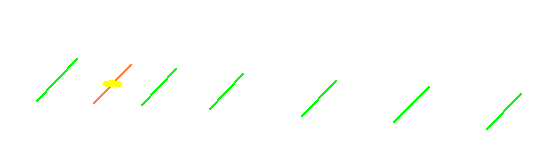

## Load python modules

In [1]:
# import other modules
import sys
import pandas as pd
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.interpolate import interp1d, interp2d, griddata
from icecream import ic
import warnings
pd.options.display.max_rows = 800
from traceback import print_exc

import seaborn as sn
sn.set()
%matplotlib inline

# Set current working directory to the notebook folder
%cd -0

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks


## Look at model metadata for the spatial averaging trials

In [2]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials[['unit','9']]

,unit,9
INPUT,,
fMHz,MHz,2320
antenna,,Yagi
Prad,W,1
dBiGain,,
horizHPBW,deg,
vertHPBW,deg,
coordinate_origin,,centre of rear reflector
xstart,m,-10
xend,m,50


## Read in the E and H data from the FEKO zip files

In [3]:
# Set the trial number and S scale factor
trial = 9
Sscale = 1000  # S in mW/m²
Sunit = 'mW/m²'
rounding = 14

# Get E and H FEKO data file locations
t = trials[str(trial)]
datadir = f'../antennas/{t.antenna_folder}/data/'
Efile = t.FEKO_Efile
Hfile = t.FEKO_Hfile

# Read in E-field AN-SOF data
print(f'{Efile = }')
cols = ['No','x','y','z','Etot',
        'Exr','Exi','Ex_abs','Ex_phase',
        'Eyr','Eyi','Ey_abs','Ey_phase',
        'Ezr','Ezi','Ez_abs','Ez_phase','dummy']
Edat = pd.read_csv(datadir + Efile, sep=';', skiprows=3,header=None)
Edat.columns = cols
Edat = Edat[['x','y','z','Etot','Exr','Exi','Eyr','Eyi','Ezr','Ezi']]
Edat = Edat.round(rounding)
display(Edat.head())

# Read in H-field AN-SOF data
print(f'{Hfile = }')
cols = ['No','x','y','z','Htot',
        'Hxr','Hxi','Hx_abs','Hx_phase',
        'Hyr','Hyi','Hy_abs','Hy_phase',
        'Hzr','Hzi','Hz_abs','Hz_phase','dummy']
Hdat = pd.read_csv(datadir + Hfile, sep=';', skiprows=3,header=None)
Hdat.columns = cols
Hdat = Hdat[['x','y','z','Htot','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']]
Hdat = Hdat.round(rounding)
display(Hdat.head())

Efile = 'HYagi_gnd_E_v2.csv'


,x,y,z,Etot,Exr,Exi,Eyr,Eyi,Ezr,Ezi
0,-10.0,0,0.00,0.036586,-0.0,0.0,-0.036209,0.005239,0.0,-0.0
1,-10.0,0,0.01,0.079927,-0.0,0.0,-0.046322,-0.065135,0.0,-0.0
2,-10.0,0,0.02,0.145340,-0.0,0.0,-0.055629,-0.134273,0.0,-0.0
3,-10.0,0,0.03,0.210845,-0.0,0.0,-0.064008,-0.200895,0.0,-0.0
4,-10.0,0,0.04,0.273247,-0.0,0.0,-0.071347,-0.263768,0.0,-0.0


Hfile = 'HYagi_gnd_H_v2.csv'


,x,y,z,Htot,Hxr,Hxi,Hyr,Hyi,Hzr,Hzi
0,-10.0,0,0.00,0.000400,-0.000385,0.000056,0.0,-0.0,0.000092,-0.000013
1,-10.0,0,0.01,0.000436,-0.000382,0.000052,0.0,-0.0,0.000118,0.000166
2,-10.0,0,0.02,0.000527,-0.000372,0.000048,0.0,-0.0,0.000142,0.000342
3,-10.0,0,0.03,0.000645,-0.000355,0.000042,0.0,-0.0,0.000164,0.000512
4,-10.0,0,0.04,0.000772,-0.000331,0.000036,0.0,-0.0,0.000182,0.000672


## Calculate S
Note that the E and H data was generated by AN_SOF which outputs **rms**, not **peak**, values 

In [4]:
# Merge Edat and Hdat dataframes into S
S = Edat.merge(Hdat,on=['x','y','z'])

# Calculate S from E² and H²
SE = Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
SH = Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
Smax = np.max([SE,SH],axis=0)

S['SE'] = SE * Sscale
S['SH'] = SH * Sscale
S['Smax'] = Smax * Sscale

# Calculate S from |E|*|H| 
S['SEH'] = S.Etot * S.Htot * Sscale

# Calculate S from time average poynting vector
  # Generate numpy array of vector phasor values for E and H* at each point
Evp = np.array([[r.Exr + r.Exi*1j, r.Eyr + r.Eyi*1j, r.Ezr + r.Ezi*1j] for r in S.itertuples()])
Hvp = np.array([[r.Hxr - r.Hxi*1j, r.Hyr - r.Hyi*1j, r.Hzr - r.Hzi*1j] for r in S.itertuples()])
  # Calculate cross product of E and H* (noting E and H are rms values for AN-SOF)
SP = np.cross(Evp,Hvp) * Sscale
  # Get real part of cross product
SP = np.real(SP)
  # Get root sum square of cross product
SP = np.linalg.norm(SP,axis=1)
  # Assign SP value
S["SP"] = SP

display(S.head())
S.describe().T

,x,y,z,Etot,Exr,Exi,Eyr,Eyi,Ezr,Ezi,...,Hxi,Hyr,Hyi,Hzr,Hzi,SE,SH,Smax,SEH,SP
0,-10.0,0,0.00,0.036586,-0.0,0.0,-0.036209,0.005239,0.0,-0.0,...,0.000056,0.0,-0.0,0.000092,-0.000013,0.003551,0.060446,0.060446,0.014650,0.014650
1,-10.0,0,0.01,0.079927,-0.0,0.0,-0.046322,-0.065135,0.0,-0.0,...,0.000052,0.0,-0.0,0.000118,0.000166,0.016945,0.071743,0.071743,0.034867,0.021670
2,-10.0,0,0.02,0.145340,-0.0,0.0,-0.055629,-0.134273,0.0,-0.0,...,0.000048,0.0,-0.0,0.000142,0.000342,0.056031,0.104750,0.104750,0.076611,0.055723
3,-10.0,0,0.03,0.210845,-0.0,0.0,-0.064008,-0.200895,0.0,-0.0,...,0.000042,0.0,-0.0,0.000164,0.000512,0.117920,0.157026,0.157026,0.136075,0.114224
4,-10.0,0,0.04,0.273247,-0.0,0.0,-0.071347,-0.263768,0.0,-0.0,...,0.000036,0.0,-0.0,0.000182,0.000672,0.198048,0.224719,0.224719,0.210962,0.190855


,count,mean,std,min,25%,50%,75%,max
x,120801.0,2.000000e+01,17.349423,-10.000000,5.000000,2.000000e+01,35.000000,50.000000
y,120801.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
z,120801.0,1.000000e+00,0.580232,0.000000,0.500000,1.000000e+00,1.500000,2.000000
Etot,120801.0,1.287234e+00,1.009809,0.010001,0.561241,9.862450e-01,1.735360,7.305820
Exr,120801.0,0.000000e+00,0.000000,-0.000000,0.000000,0.000000e+00,0.000000,-0.000000
Exi,120801.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
Eyr,120801.0,2.647664e-04,1.160034,-6.597730,-0.571495,-1.104810e-03,0.570783,6.951810
Eyi,120801.0,1.539341e-04,1.153699,-7.209650,-0.566292,-1.743590e-03,0.564891,6.824520
Ezr,120801.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
Ezi,120801.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


Note that SP has a *lower* mean value compared to SE and SH

In [5]:
# Create S2 long form version of S for Seaborn plots
cols = ['x', 'y', 'z', 'SE', 'SH', 'Smax', 'SEH', 'SP']
id_vars = ('x', 'y', 'z')
value_vars = ('SE', 'SH', 'Smax', 'SEH', 'SP')
S2 = S[cols].melt(id_vars=id_vars,value_vars=value_vars,var_name='S type',value_name='S')
S2 = S2.sort_values(['x','y','z'])
S2

,x,y,z,S type,S
0,-10.0,0,0.0,SE,0.003551
120801,-10.0,0,0.0,SH,0.060446
241602,-10.0,0,0.0,Smax,0.060446
362403,-10.0,0,0.0,SEH,0.014650
483204,-10.0,0,0.0,SP,0.014650
...,...,...,...,...,...
120800,50.0,0,2.0,SE,0.421324
241601,50.0,0,2.0,SH,0.426905
362402,50.0,0,2.0,Smax,0.426905
483203,50.0,0,2.0,SEH,0.424105


## Calculate spatial averages

In [7]:
# function for calculating weighted spatial averages
def spatavg(df, weights, zlist):
    try:
        mask = df.z.isin(zlist)
    except:
        print(zlist)
    Spts = df.loc[mask,:].iloc[:,-1]
    weights = np.array(weights)
    weights = weights / weights.sum()
    sa = (weights * Spts).sum()
    return sa    

# function for calculating weights for Simpsons 1/3 rule
def S13_weights(n):
    '''Calculates the weights for Simpsons 1/3 rule
       n = no. of points
       intervals = no. of intervals'''
    intervals = n - 1
    assert intervals >= 2, f'No. of intervals ({n-1}) must be >= 2'
    assert intervals%2 == 0, f'No. of intervals ({n-1}) must be an even number'
    if intervals == 2:
        w = [1,4,1]
    else:
        w = [1]
        w += [4,2] * int((n-3)/2)
        w += [4,1]
    return w

# Create list of z values for averaging points
  # 1.6m
z_1pt       = [1.5]
z_16m_5pt   = [0,0.4,0.8,1.2,1.6]
z_16m_9pt   = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6]
z_16m_21pt  = np.round(np.arange(0,1.68,0.08),2)
z_16m_161pt = np.round(np.arange(0,1.61,0.01),2)
  # 2.0m
z_20m_5pt   = [0,0.5,1.0,1.5,2.0]
z_20m_9pt   = [0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0]
z_20m_20pt = np.round(np.arange(0.1,2.1,0.1),2)  # no point at z=0 as per IEC62232
z_20m_201pt = np.round(np.arange(0,2.01,0.01),2)

# Create weights for averaging points
w_1pt     = [1]
w_5pt     = [1]*5
w_5pt_S13 = S13_weights(5)
w_9pt     = [1]*9
w_9pt_S13 = S13_weights(9)
w_20pt    = [1]*20
w_21pt    = [1]*21
w_21pt_S13 = S13_weights(21)
w_161pt   = [1] * 161
w_161pt_S13 = S13_weights(161)
w_201pt   = [1]*201
w_201pt_S13 = S13_weights(201)

# Create spatial averaging specifications list
Savglist = [['SP','1.6m-161-S13', z_16m_161pt, w_161pt_S13],
            ['SP','1.6m-161', z_16m_161pt, w_161pt],            
            ['SEH','1.6m-161-S13', z_16m_161pt, w_161pt_S13],
            ['SP','1.6m-21-S13', z_16m_21pt, w_21pt_S13],
            ['SP','1.6m-9-S13', z_16m_9pt, w_9pt_S13],
            ['SP','1.6m-5-S13', z_16m_5pt, w_5pt_S13],
            ['SE','1pt@1.5m', z_1pt, w_1pt],
            ['SE','1.6m-161-S13', z_16m_161pt, w_161pt_S13],
            ['SH','1.6m-161-S13', z_16m_161pt, w_161pt_S13],
            ['SP','2.0m-201-S13', z_20m_201pt, w_201pt_S13],
            ['SE','2.0m-20', z_20m_20pt, w_20pt],
           ]

In [8]:
Slist = []
for (Si, avg_scheme, zlist, weights) in Savglist:
    ic(Si, avg_scheme)
    SS = S.groupby('x')[['z',Si]].apply(spatavg, weights, zlist)
    Slist.append(SS)
    SS.name = Si + '_' + avg_scheme
    
Savg = pd.DataFrame(Slist).T
Savg.head()

ic| Si: 'SP', avg_scheme: '1.6m-161-S13'
ic| Si: 'SP', avg_scheme: '1.6m-161'
ic| Si: 'SEH', avg_scheme: '1.6m-161-S13'
ic| Si: 'SP', avg_scheme: '1.6m-21-S13'
ic| Si: 'SP', avg_scheme: '1.6m-9-S13'
ic| Si: 'SP', avg_scheme: '1.6m-5-S13'
ic| Si: 'SE', avg_scheme: '1pt@1.5m'
ic| Si: 'SE', avg_scheme: '1.6m-161-S13'
ic| Si: 'SH', avg_scheme: '1.6m-161-S13'
ic| Si: 'SP', avg_scheme: '2.0m-201-S13'
ic| Si: 'SE', avg_scheme: '2.0m-20'


,SP_1.6m-161-S13,SP_1.6m-161,SEH_1.6m-161-S13,SP_1.6m-21-S13,SP_1.6m-9-S13,SP_1.6m-5-S13,SE_1pt@1.5m,SE_1.6m-161-S13,SH_1.6m-161-S13,SP_2.0m-201-S13,SE_2.0m-20
x,,,,,,,,,,,
-10.0,0.382454,0.380744,0.391095,0.383179,0.345715,0.340670,0.726753,0.392581,0.392183,0.385608,0.413359
-9.9,0.384495,0.382560,0.393388,0.384748,0.360067,0.358053,0.766129,0.394755,0.394691,0.392991,0.418160
-9.8,0.386039,0.384008,0.395132,0.386083,0.379243,0.380178,0.761293,0.396337,0.396723,0.399746,0.421080
-9.7,0.387452,0.385451,0.396714,0.387120,0.401689,0.404191,0.710316,0.397740,0.398634,0.405366,0.422528
-9.6,0.389113,0.387288,0.398613,0.387873,0.424644,0.427455,0.617695,0.399459,0.400844,0.409602,0.423358


In [9]:
Savg.describe().T

,count,mean,std,min,25%,50%,75%,max
SP_1.6m-161-S13,601.0,6.141961,6.561324,0.382454,1.535459,2.969868,9.057153,28.670261
SP_1.6m-161,601.0,6.131577,6.555619,0.380744,1.533935,2.969558,9.040713,28.680578
SEH_1.6m-161-S13,601.0,6.330505,6.801772,0.391095,1.560040,3.039760,9.171955,29.770922
SP_1.6m-21-S13,601.0,6.158501,6.644333,0.383179,1.526267,2.970277,8.707078,28.588501
SP_1.6m-9-S13,601.0,6.084138,6.509568,0.081644,1.540751,2.968237,9.068603,28.668903
SP_1.6m-5-S13,601.0,5.855783,6.571235,0.081740,1.493370,2.993387,7.975820,28.581587
SE_1pt@1.5m,601.0,8.166315,12.185685,0.012476,1.231504,2.614191,9.260925,66.729124
SE_1.6m-161-S13,601.0,6.413171,6.920080,0.392581,1.567320,3.038474,9.402153,30.897676
SH_1.6m-161-S13,601.0,6.422603,6.929749,0.392183,1.568464,3.042741,9.395687,30.864056
SP_2.0m-201-S13,601.0,6.861893,7.956894,0.385608,1.439706,2.891344,9.212454,36.104186


## Plots

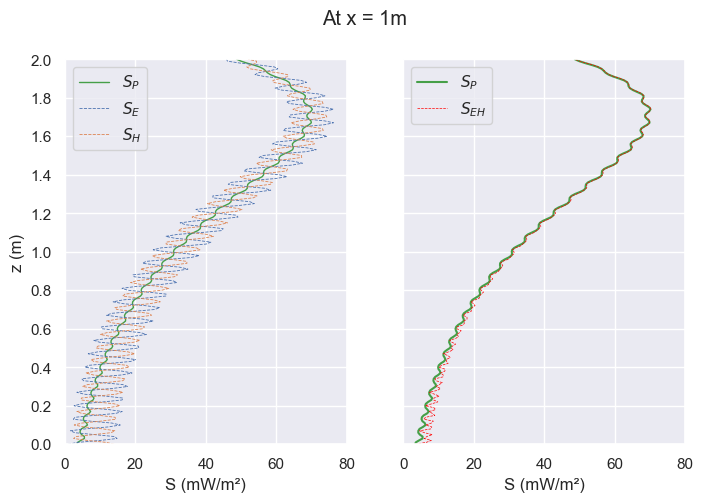

In [14]:
xdat = 1
df = S[S.x==xdat]

# plt.style.use('seaborn-whitegrid')
sn.set('notebook')
fig, ax = plt.subplots(1,2,figsize=(8,5),sharex=True,sharey=True)

ax[0].plot(df['SP'],df.z,'-',lw=1,color='green',alpha=0.7,label='$S_P$')
for Si in ['SE', 'SH']:
    ax[0].plot(df[Si], df.z, '--', lw=0.6, label=f'$S_{Si[1:]}$')
Speak = df.SP.max()
xhigh = round(Speak/10)*10 + 10
ax[0].set_xlim(left=0,right=xhigh)
ax[0].set_xlabel('S (mW/m²)')
ax[0].set_ylabel('z (m)')
ax[0].legend()

ax[1].plot(df['SP'], df.z, '-', lw=1.5, color='green', alpha=0.7,label='$S_P$')
ax[1].plot(df['SEH'],  df.z,'--',lw=0.5, color='red', alpha=1,label='$S_{EH}$')
ax[1].set_xlabel('S (mW/m²)')
ax[1].legend()

plt.yticks(np.arange(0,2.2,0.2))
plt.ylim(0,2)
fig.suptitle(f'At x = {xdat}m');

SP_1.6m-161
SEH_1.6m-161-S13
SP_1.6m-21-S13
SP_1.6m-9-S13
SP_1.6m-5-S13
SE_1pt@1.5m
SE_1.6m-161-S13
SH_1.6m-161-S13
SP_2.0m-201-S13
SE_2.0m-20


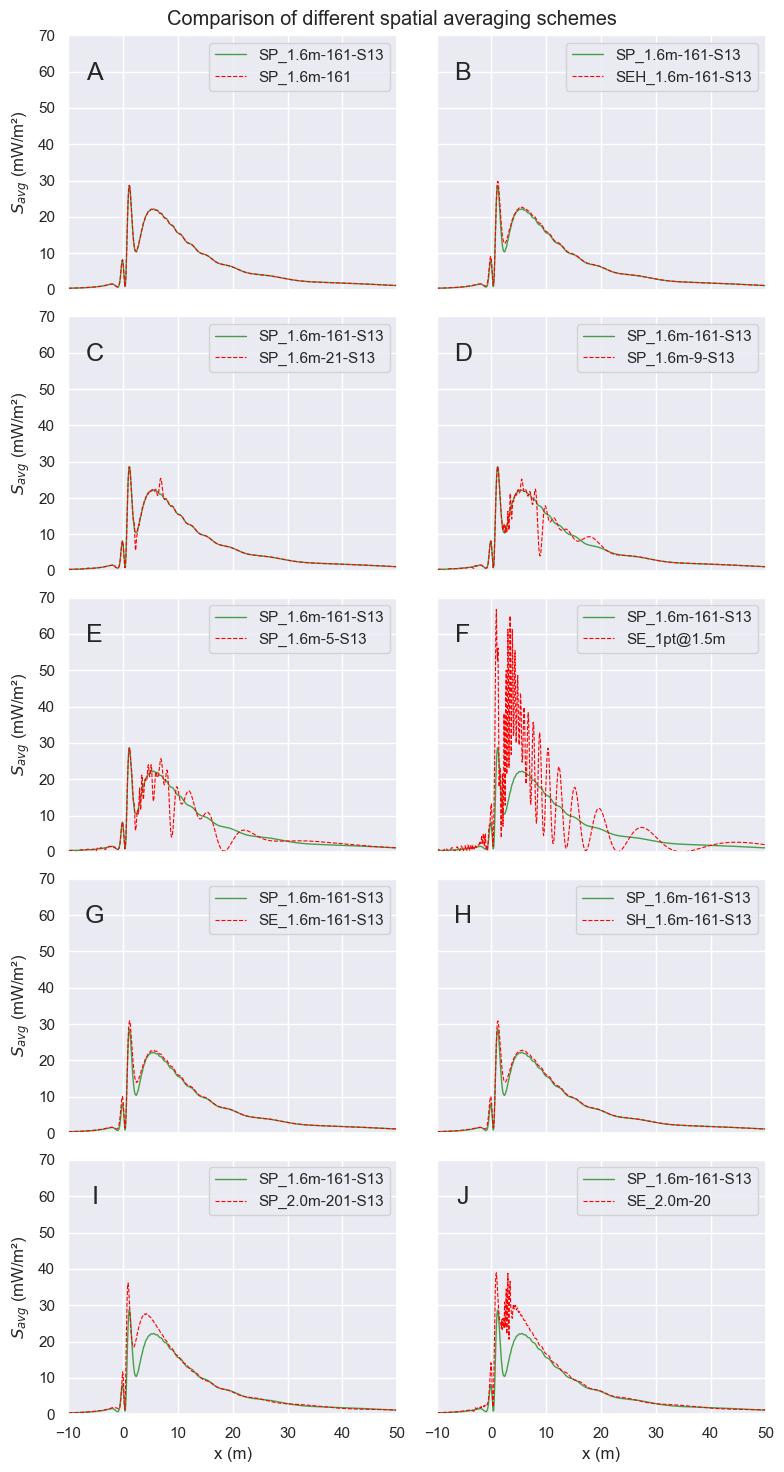

In [205]:
sn.set('notebook')
Scols = ['SE', 'SH', 'SEH']
fig, ax = plt.subplots(5,2,figsize=(8,15),sharex=True,sharey=True)
ax = ax.flatten()
letters = 'ABCDEFGHIJKLMNOQRSTUVWXYZ'

for i, Si in enumerate(Savg.drop(columns='SP_1.6m-161-S13')):
    print(Si)
    ax[i].plot(Savg.index, Savg['SP_1.6m-161-S13'],'-',lw=1,color='green',
               alpha=0.7,label='SP_1.6m-161-S13')
    ax[i].plot(Savg.index, Savg[Si],'--',lw=0.8,color='red',alpha=1,label=Si)
    ax[i].set_xlim(left=-10,right=50)
    if i%2 == 0:
        ax[i].set_ylabel('$S_{avg}$ (mW/m²)')
    if i >= len(ax) - 2:
        ax[i].set_xlabel('x (m)')
    ax[i].text(0.08, 0.85, letters[i], horizontalalignment='center', fontsize=18,
                 verticalalignment='center', transform=ax[i].transAxes)
    
    ax[i].legend()

plt.ylim(0,None)
plt.xlim(-10,50)
fig.suptitle(f'Comparison of different spatial averaging schemes')
fig.tight_layout()

x
-1.2    2.115304
-1.1    2.261633
-1.0    2.264008
 0.4    4.575356
 0.5    3.570436
 0.6    2.724179
 0.7    2.166253
 2.4    2.013345
 2.5    2.008708
dtype: float64

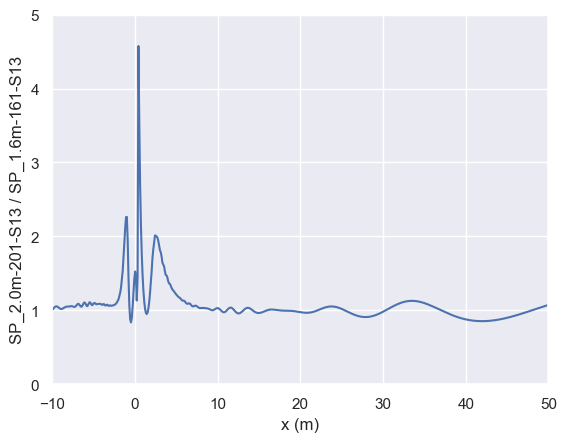

In [32]:
ratio = Savg['SP_2.0m-201-S13'] / Savg['SP_1.6m-161-S13']
display(ratio[ratio >= 2])

plt.plot(Savg.index, ratio)
plt.ylim(0,5)
plt.xlim(-10,50)
plt.xlabel('x (m)')
plt.ylabel(r'SP_2.0m-201-S13 / SP_1.6m-161-S13');

## Scratch

In [66]:
# creating an 2D input array
arr1 = [2+3j,4+5j,6+7j]
arr2 = [3+2j,5+4j,7+16j]

# Get cross product of numpy arrays in 2D
arr3 = np.cross(arr1, arr2)

print(arr3)
np.real(arr3)

[-54.+40.j  38.-20.j  -4. +0.j]


array([-54.,  38.,  -4.])

In [56]:
# Calculate time average value of Poynting vector
Edat2 = Edat.loc[:3,:].copy()
Hdat2 = Hdat.loc[:3,:].copy()

Evp = np.array([[r.Exr + r.Exi*1j, r.Eyr + r.Eyi*1j, r.Ezr + r.Ezi*1j] for r in Edat2.itertuples()])
Hvp = np.array([[r.Hxr - r.Hxi*1j, r.Hyr - r.Hyi*1j, r.Hzr - r.Hzi*1j] for r in Hdat2.itertuples()])

print('Evp\n',Evp.round(5))
print('\nHvp\n',Hvp.round(7))

p2 = np.cross(Evp,Hvp) * 1000
print("\nCross product")
display(p2.round(5))

p2 = np.real(p2)
print("\nReal part of cross product")
display(p2)

p2 = np.linalg.norm(p2,axis=1)
print("\nRoot sum square")
display(p2)

Evp
 [[0.03621-0.00524j 0.     +0.j      0.     +0.j     ]
 [0.04632+0.06513j 0.     +0.j      0.     +0.j     ]
 [0.05563+0.13427j 0.     +0.j      0.     +0.j     ]
 [0.06401+0.2009j  0.     +0.j      0.     +0.j     ]]

Hvp
 [[ 0.000e+00+0.000e+00j -3.853e-04-5.640e-05j  9.230e-05+1.330e-05j]
 [ 0.000e+00+0.000e+00j -3.821e-04-5.240e-05j  1.183e-04-1.661e-04j]
 [ 0.000e+00+0.000e+00j -3.718e-04-4.770e-05j  1.422e-04-3.422e-04j]
 [ 0.000e+00+0.000e+00j -3.546e-04-4.230e-05j  1.636e-04-5.120e-04j]]

Cross product


array([[ 0.     +0.000e+00j, -0.00341+0.000e+00j, -0.01425-2.000e-05j],
       [ 0.     +0.000e+00j, -0.01629-1.000e-05j, -0.01429-2.731e-02j],
       [ 0.     +0.000e+00j, -0.05386-5.000e-05j, -0.01428-5.258e-02j],
       [ 0.     +0.000e+00j, -0.11334-1.000e-04j, -0.0142 -7.395e-02j]])


Real part of cross product


array([[ 0.        , -0.00341146, -0.01424691],
       [ 0.        , -0.01629399, -0.01428665],
       [ 0.        , -0.05386193, -0.01428258],
       [ 0.        , -0.11333865, -0.01419744]])


Root sum square


array([0.01464966, 0.02167031, 0.05572342, 0.11422442])

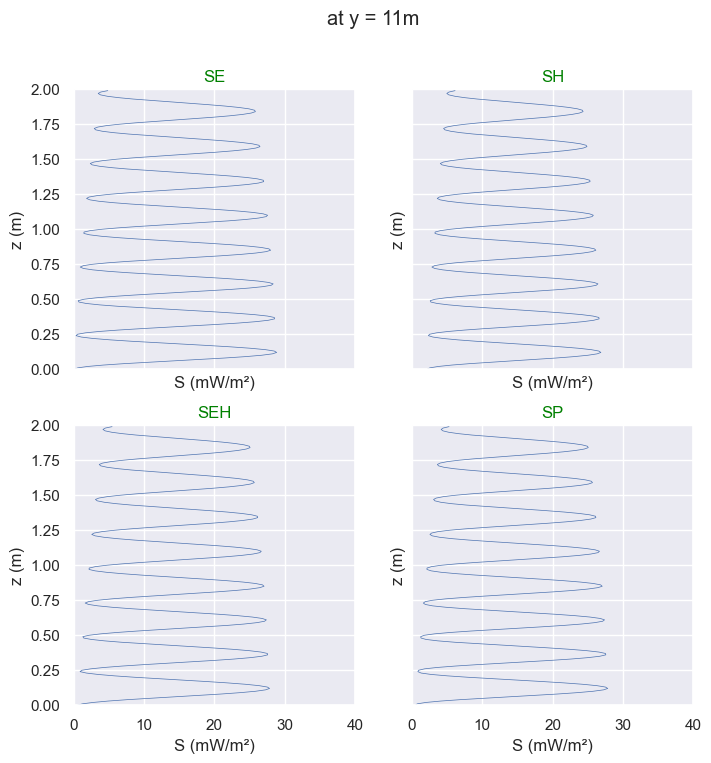

In [6]:
ydat = 11
df = S[S.y==ydat]
Scols = ['SE', 'SH', 'SEH', 'SP']
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
plt.suptitle(f'at y = {ydat}m')
axes = axes.flatten()

Speak = df.SP.max()
xhigh = round(Speak/10)*10 + 10

for Si, ax in zip(Scols,axes):
    ax.plot(df[Si],df.z,'-', lw=0.5, alpha=1)
    ax.set_xlim(left=0,right=xhigh)
    ax.set_ylim(bottom=0,top=2)
    ax.set_title(Si,color='green')
    ax.set_xlabel('S (mW/m²)')
    ax.set_ylabel('z (m)')

In [106]:
for (Si, avg_scheme, indexes, weights) in Savglist:
    ic(Si, avg_scheme)
    SS = S.groupby('x')[Si].apply(spatavg, weights, indexes)
    SS.name = Si + '_' + avg_scheme
    display(SS.head())

ic| Si: 'SP', avg_scheme: '1.6m-161'


x
-10.0    0.380744
-9.9     0.382560
-9.8     0.384008
-9.7     0.385451
-9.6     0.387288
Name: SP_1.6m-161, dtype: float64

ic| Si: 'SP', avg_scheme: '1.6m-161-S13'


x
-10.0    0.382454
-9.9     0.384495
-9.8     0.386039
-9.7     0.387452
-9.6     0.389113
Name: SP_1.6m-161-S13, dtype: float64

ic| Si: 'SE', avg_scheme: '1.6m-161-S13'


x
-10.0    0.392581
-9.9     0.394755
-9.8     0.396337
-9.7     0.397740
-9.6     0.399459
Name: SE_1.6m-161-S13, dtype: float64

ic| Si: 'SH', avg_scheme: '1.6m-161-S13'


x
-10.0    0.392183
-9.9     0.394691
-9.8     0.396723
-9.7     0.398634
-9.6     0.400844
Name: SH_1.6m-161-S13, dtype: float64

ic| Si: 'SP', avg_scheme: '1.6m-9-S13'


x
-10.0    0.345715
-9.9     0.360067
-9.8     0.379243
-9.7     0.401689
-9.6     0.424644
Name: SP_1.6m-9-S13, dtype: float64

ic| Si: 'SP', avg_scheme: '1.6m-5-S13'


x
-10.0    0.340670
-9.9     0.358053
-9.8     0.380178
-9.7     0.404191
-9.6     0.427455
Name: SP_1.6m-5-S13, dtype: float64

ic| Si: 'SP', avg_scheme: '2.0m-201-S13'


x
-10.0    0.385608
-9.9     0.392991
-9.8     0.399746
-9.7     0.405366
-9.6     0.409602
Name: SP_2.0m-201-S13, dtype: float64

ic| Si: 'SP', avg_scheme: '2.0m-9-S13'


x
-10.0    0.441072
-9.9     0.475453
-9.8     0.490171
-9.7     0.485582
-9.6     0.465288
Name: SP_2.0m-9-S13, dtype: float64